# Communities

In [1]:
from utils_globals import *
import pickle
import os
import re
from utils_wiki import get_category_data
from utils_network import filter_graph_by_attribute, count_nodes_by_attribute
from community import community_louvain
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# load graph:
S = pickle.load(open(PICKLE_DIR + "/graph.pkl", "rb"))
S_undirected = pickle.load(open(PICKLE_DIR + "/graph_undirected.pkl", "rb"))

## Extraction using `subfields` and `tradition`

### (A) Extracting `subfield`
From https://en.wikipedia.org/wiki/Lists_of_philosophers

#### (A.1) Fetching data
Two options are below either
- `Option 1`: Fetching data anew from Wikipedia
- `Option 2`: Using pickle file from last time option 1 was run

In [2]:
subfield_links = [
		"List of aestheticians",
		"List of critical theorists",
		"List of environmental philosophers",
		"List of epistemologists",
		"List of ethicists",
		"List of existentialists",
		"List of feminist philosophers",
		"List of secular humanists", #List of Humanists redirect
		"List of logicians",
		"List of metaphysicians",
		"Index of sociopolitical thinkers", #List of Social and Political Philosophers redirect
		"List of phenomenologists",
		"List of philosophers of language",
		"List of philosophers of mind",
		"List of philosophers of religion",
		"List of philosophers of science",
		"List of political philosophers",
		"List of political theorists",
		"List of rationalists",
		"List of utilitarians"
]

##### -> `Option 1`: **Fetch the data from Wikipedia** (takes around 5 seconds)

In [3]:
replace_terms_subfields = [("List of", ""), ("Index of", "")]
clean_subfield_data, philosopher_subfield_info = get_category_data(
    subfield_links, replace_terms_subfields, verbose=True
)
pickle.dump(philosopher_subfield_info, open(PICKLE_DIR + "/philosopher_subfield_info.pkl", "wb")) # Saved as local version for later use

print("Total =", len(philosopher_subfield_info))

- aestheticians: 86
- critical theorists: 107
- environmental philosophers: 80
- epistemologists: 122
- ethicists: 287
- existentialists: 60
- feminist philosophers: 134
- secular humanists: 413
- logicians: 291
- metaphysicians: 185
- sociopolitical thinkers: 245
- phenomenologists: 24
- philosophers of language: 141
- philosophers of mind: 140
- philosophers of religion: 110
- philosophers of science: 111
- political philosophers: 199
- political theorists: 137
- rationalists: 28
- utilitarians: 104
Total = 2184


##### -> `Option 2`: **Use local pickle file** from last time option 1 was run

In [4]:
philosopher_subfield_info = pickle.load(open(PICKLE_DIR + "/philosopher_subfield_info.pkl", "rb"))

#### (A.2) Creating `S.subfields` network

In [5]:
S_subfields = filter_graph_by_attribute(
    graph=S_undirected,
    attribute_info=philosopher_subfield_info,
    attribute_name='subfields',
    verbose=True
)
print("-"*50)
count_nodes_by_attribute(S_subfields, 'subfields', verbose=True)
print("-"*50)


Did not find subfields for: 768 philosophers (therefore not included in the filtered graph)
 -> Example of removed nodes: ['Sophie_de_Condorcet', 'Charles_Babbage', 'Felix_Krueger']
Original graph: 1362 nodes and 8887 edges
Filtered 'subfields' graph: 594 nodes and 4220 edges
--------------------------------------------------
Number of nodes by subfields:
 -> critical theorists: 41
 -> sociopolitical thinkers: 131
 -> political philosophers: 135
 -> political theorists: 73
 -> philosophers of language: 68
 -> epistemologists: 78
 -> philosophers of religion: 49
 -> metaphysicians: 119
 -> philosophers of mind: 57
 -> ethicists: 115
 -> philosophers of science: 45
 -> utilitarians: 29
 -> aestheticians: 51
 -> logicians: 89
 -> feminist philosophers: 22
 -> secular humanists: 34
 -> rationalists: 17
 -> phenomenologists: 11
 -> existentialists: 7
 -> environmental philosophers: 8
--------------------------------------------------


### (B) Using `tradition` (western/eastern divide)

#### (B.1) Extracting information from wikipedia

Two options are below either
- `Option 1`: Fetching data anew from Wikipedia
- `Option 2`: Using pickle file from last time option 1 was run

##### -> `Option 1`: Extract from wikipedia

In [6]:
tradition_links = [
	"Timeline of Eastern philosophers",
	"Timeline of Western philosophers"
]

replace_terms_traditions = [("Timeline of", "")]
clean_tradition_data, philosopher_tradition_info = get_category_data(
    tradition_links, replace_terms_traditions, verbose=True
)
pickle.dump(philosopher_tradition_info, open(PICKLE_DIR + "/philosopher_tradition_info.pkl", "wb")) # Saved as local version for later use
print("Total =", len(philosopher_tradition_info))

- Eastern philosophers: 343
- Western philosophers: 565
Total = 893


##### -> `Option 2`: **Use local pickle file** from last time option 1 was run

In [7]:
philosopher_tradition_info = pickle.load(open(PICKLE_DIR + "/philosopher_tradition_info.pkl", "rb"))

#### (B.2) Creating `S_tradition` network

In [8]:
S_tradition = filter_graph_by_attribute(
    graph=S_undirected,
    attribute_info=philosopher_tradition_info,
    attribute_name='tradition',
    verbose=True
)

print("-"*50)
count_nodes_by_attribute(S_tradition, 'tradition', verbose=True)
print("-"*50)

Did not find tradition for: 1016 philosophers (therefore not included in the filtered graph)
 -> Example of removed nodes: ['Sophie_de_Condorcet', 'Charles_Babbage', 'Felix_Krueger']
Original graph: 1362 nodes and 8887 edges
Filtered 'tradition' graph: 346 nodes and 2561 edges
--------------------------------------------------
Number of nodes by tradition:
 -> Western philosophers: 279
 -> Eastern philosophers: 69
--------------------------------------------------


## Partitioning

### Imports and definitions

In [9]:
from community import community_louvain
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans

def create_partition_using_attribute(graph, attribute_name):
	partition = {}
	for node, data in graph.nodes(data=True):
		attribute = data.get(attribute_name)
		if isinstance(attribute, list):
			attribute = attribute[0]
		if attribute is not None:
				partition[node] = attribute
	return partition

def get_louvain_modularity(graph, partition_dict):
	return f"{community_louvain.modularity(partition_dict, graph):.4f}"

def plot_partition_heatmap(graph, attribute_partition, louvain_partition, attribute_name, top_n=7, title="Confusion Matrix"):
    """
    Plots a confusion matrix heatmap comparing attribute-based partition and Louvain community partition.

    Args:
        graph (networkx.Graph): The graph to analyze.
        attribute_partition (dict): Partition mapping nodes to their attributes.
        louvain_partition (dict): Louvain partition mapping nodes to communities.
        attribute_name (str): Name of the attribute (e.g., 'subfields' or 'tradition').
        top_n (int): Number of top attributes and communities to consider for the heatmap.
        title (str): Title of the heatmap.
    """
    # Step 1: Identify top attributes and communities
    attribute_counts = Counter(attribute_partition.values())
    top_attributes = [attribute for attribute, _ in attribute_counts.most_common(top_n)]

    community_counts = Counter(louvain_partition.values())
    top_communities = [community for community, _ in community_counts.most_common(top_n)]

    # Step 2: Map attributes and communities to matrix indices
    attribute_to_index = {attribute: idx for idx, attribute in enumerate(top_attributes)}
    community_to_index = {community: idx for idx, community in enumerate(top_communities)}

    # Step 3: Initialize confusion matrix D
    D = np.zeros((top_n, top_n), dtype=int)

    # Step 4: Populate the confusion matrix
    for node in graph.nodes:
        attribute = attribute_partition.get(node)  # Get node's attribute
        community = louvain_partition.get(node)  # Get node's Louvain community

        # Only consider top attributes and communities
        if community in community_to_index and attribute in attribute_to_index:
            i = attribute_to_index[attribute]
            j = community_to_index[community]
            D[i, j] += 1

    # Step 5: Create the heatmap
    plt.figure(figsize=(7, 7))
    plt.imshow(D, interpolation='nearest', cmap='Blues')

    # Add text annotations for each cell
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            plt.text(j, i, int(D[i, j]), ha="center", va="center", color="black")

    # Add titles, labels, and ticks
    plt.title(title)
    plt.xlabel('Communities')
    plt.ylabel(f'{attribute_name.capitalize()}')

    # Set tick labels
    plt.xticks(np.arange(len(top_communities)), [f"C {c}" for c in top_communities])
    plt.yticks(np.arange(len(top_attributes)), top_attributes)

    # Add a color bar
    plt.colorbar()
    plt.show()

### (A) Partitioning using `S_subfields`

Each node is characterized by the first `subfield` if there are multiple.

In [10]:
subfields_partition = create_partition_using_attribute(S_subfields, 'subfields')
subfields_partition_modularity = get_louvain_modularity(S_subfields, subfields_partition)
print("Subfields partion Modularity = ", subfields_partition_modularity)

louvain_partition_S_subfields = community_louvain.best_partition(S_subfields, random_state=RANDOM_STATE)
print("Louvain partion Modularity = ", get_louvain_modularity(S_subfields, louvain_partition_S_subfields))

# louvain_partition_S_subfields_kmeans = louvain_kmeans_partition(S_subfields, len(subfield_links))
# print("Louvain partion (with KMeans community limit) Modularity = ", get_louvain_modularity(S_subfields, louvain_partition_S_subfields_kmeans))

Subfields partion Modularity =  0.0872
Louvain partion Modularity =  0.4293


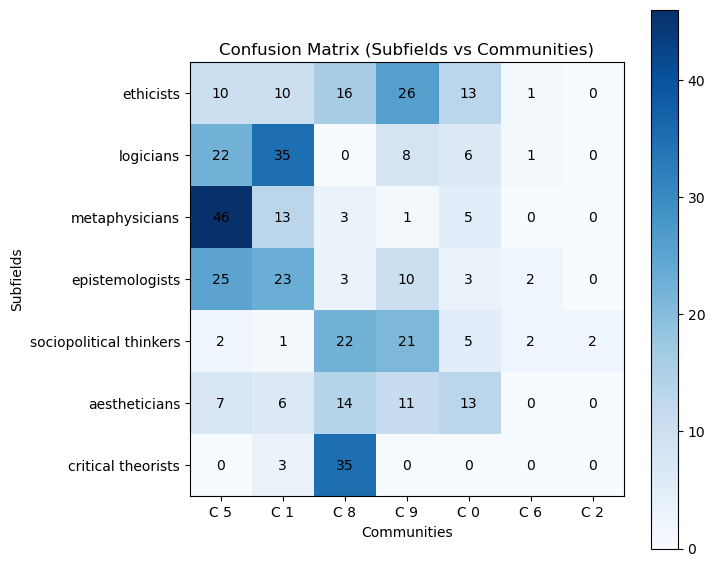

In [11]:
plot_partition_heatmap(
    graph=S_subfields,
    attribute_partition=subfields_partition,
    louvain_partition=louvain_partition_S_subfields,
    attribute_name='subfields',
    title='Confusion Matrix (Subfields vs Communities)'
)

### (B) Partitioning using `S_tradition`

In [12]:
tradition_partition = create_partition_using_attribute(S_tradition, 'tradition')
tradition_partition_modularity = get_louvain_modularity(S_tradition, tradition_partition)

print("Tradition partion Modularity = ", tradition_partition_modularity)

louvain_partition_S_tradition = community_louvain.best_partition(S_tradition, random_state=RANDOM_STATE)
print("Louvain partion Modularity = ", get_louvain_modularity(S_tradition, louvain_partition_S_tradition))

# louvain_partition_S_tradition_kmeans = louvain_kmeans_partition(S_tradition, 2)
# print("Louvain partion (with KMeans community limit) Modularity = ", get_louvain_modularity(S_tradition, louvain_partition_S_tradition_kmeans))

Tradition partion Modularity =  0.0802
Louvain partion Modularity =  0.3946


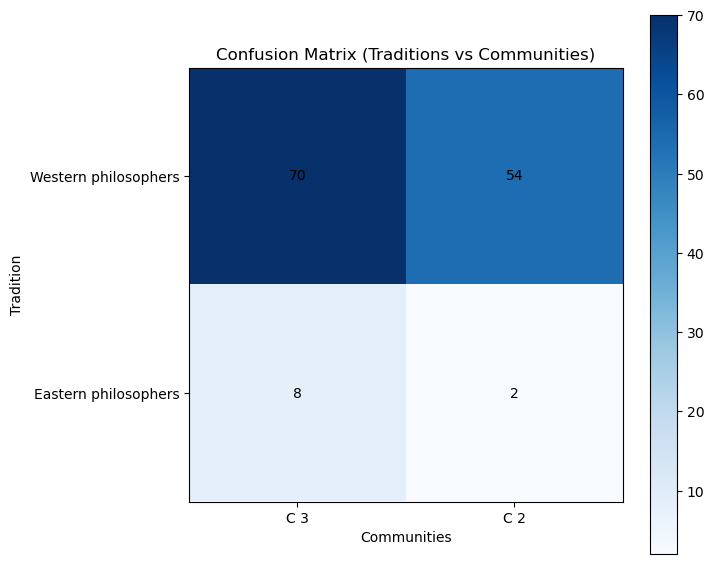

In [13]:
plot_partition_heatmap(
    graph=S_tradition,
    attribute_partition=tradition_partition,
    louvain_partition=louvain_partition_S_tradition,
    attribute_name='tradition',
    top_n=2,
	title='Confusion Matrix (Traditions vs Communities)'
)

#